In [3]:
import numpy as np
import torch
import tifffile
from pathlib import Path
import time
import os
import torch.nn as nn
import torch.optim as optim

PROJECT_ROOT = Path("/mnt/home/dchhantyal/3d-cnn-classification")
import sys
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
sys.path.append(str(PROJECT_ROOT))

In [4]:
from model import ConvRNN, Config, resize_volume, NucleusDataset, DataLoader, RandomAugmentation3D

In [5]:
DATA_ROOT_DIR = (
    "/mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset"  #
)

config = Config() 

In [6]:
# 1. Initialize Model, Loss, and Optimizer
model = ConvRNN(num_classes=config.num_classes).to(config.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

In [7]:
# 2. Prepare DataLoaders
full_dataset = NucleusDataset(root_dir=DATA_ROOT_DIR)

In [8]:
 # 1. Create a dataset for training WITH the augmentation transform
train_full_dataset = NucleusDataset(
    root_dir=DATA_ROOT_DIR, transform=RandomAugmentation3D()
)

# 2. Create a second dataset for validation WITHOUT the transform
val_full_dataset = NucleusDataset(root_dir=DATA_ROOT_DIR, transform=None)

# 3. Perform the stratified split on indices
labels = [sample[1] for sample in train_full_dataset.samples]
indices = list(range(len(train_full_dataset)))
train_indices, val_indices = train_test_split(
    indices, test_size=0.2, random_state=42, stratify=labels
)

# 4. Create Subsets using the correct dataset instance for each
train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)
# --- END OF MODIFICATION ---

train_loader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
)

print(f"Found {len(full_dataset)} total samples.")
print(
    f"Training on {len(train_dataset)} samples, validating on {len(val_dataset)} samples."
)
print(
    f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters."
)

Found 605 total samples.
Training on 484 samples, validating on 121 samples.
Model has 97,731 trainable parameters.


In [10]:
from collections import Counter

In [11]:
Counter(labels)

Counter({0: 212, 1: 199, 2: 194})

In [14]:
from matplotlib import pyplot as plt

(array([0.00184719, 0.00184719, 0.0014367 , 0.00174457, 0.00164195,
        0.00153932, 0.00164195, 0.00174457, 0.00164195, 0.00164195,
        0.00153932, 0.00184719, 0.00174457, 0.00164195, 0.00184719,
        0.00153932, 0.00153932, 0.0014367 , 0.00153932, 0.00164195,
        0.00184719, 0.00153932, 0.00194981, 0.00164195, 0.0014367 ,
        0.00184719, 0.00123146, 0.00153932, 0.00184719, 0.00174457]),
 array([  0.        ,  20.13333333,  40.26666667,  60.4       ,
         80.53333333, 100.66666667, 120.8       , 140.93333333,
        161.06666667, 181.2       , 201.33333333, 221.46666667,
        241.6       , 261.73333333, 281.86666667, 302.        ,
        322.13333333, 342.26666667, 362.4       , 382.53333333,
        402.66666667, 422.8       , 442.93333333, 463.06666667,
        483.2       , 503.33333333, 523.46666667, 543.6       ,
        563.73333333, 583.86666667, 604.        ]),
 <BarContainer object of 30 artists>)

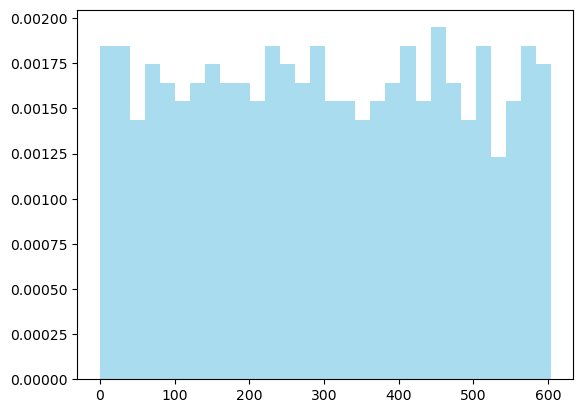

In [18]:
plt.hist(train_indices, bins=30, density=True, alpha=0.7, color='skyblue')

(array([0.00125219, 0.00083479, 0.00250438, 0.00125219, 0.00166959,
        0.00208699, 0.00166959, 0.00125219, 0.00208699, 0.00125219,
        0.00250438, 0.00083479, 0.00125219, 0.0004174 , 0.00166959,
        0.00292178, 0.00125219, 0.00208699, 0.00292178, 0.00208699,
        0.00083479, 0.00166959, 0.00083479, 0.00166959, 0.00083479,
        0.00250438, 0.00250438, 0.00292178, 0.00125219, 0.00166959]),
 array([  1. ,  20.8,  40.6,  60.4,  80.2, 100. , 119.8, 139.6, 159.4,
        179.2, 199. , 218.8, 238.6, 258.4, 278.2, 298. , 317.8, 337.6,
        357.4, 377.2, 397. , 416.8, 436.6, 456.4, 476.2, 496. , 515.8,
        535.6, 555.4, 575.2, 595. ]),
 <BarContainer object of 30 artists>)

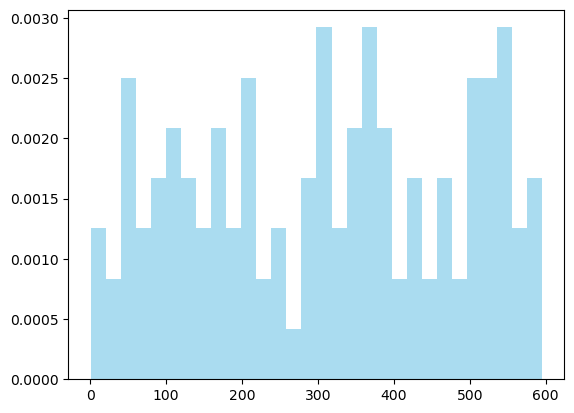

In [17]:
plt.hist(val_indices, bins=30, density=True, alpha=0.7, color='skyblue')

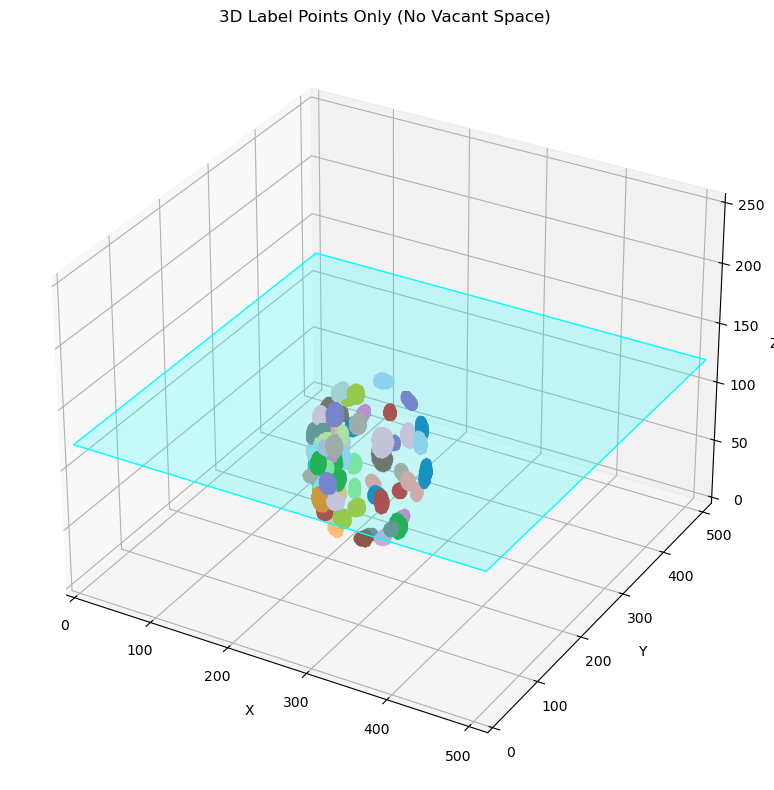

In [15]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, c=color_indices, cmap=ListedColormap(base_cmap.colors), s=2)

# Add mid-Z plane as before
plane = Poly3DCollection(plane_verts, color="cyan", alpha=0.2)
ax.add_collection3d(plane)

ax.set_xlim(0, xlim)
ax.set_ylim(0, ylim)
ax.set_zlim(0, label_stack.shape[0])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("3D Label Points Only (No Vacant Space)")
plt.tight_layout()
plt.show()


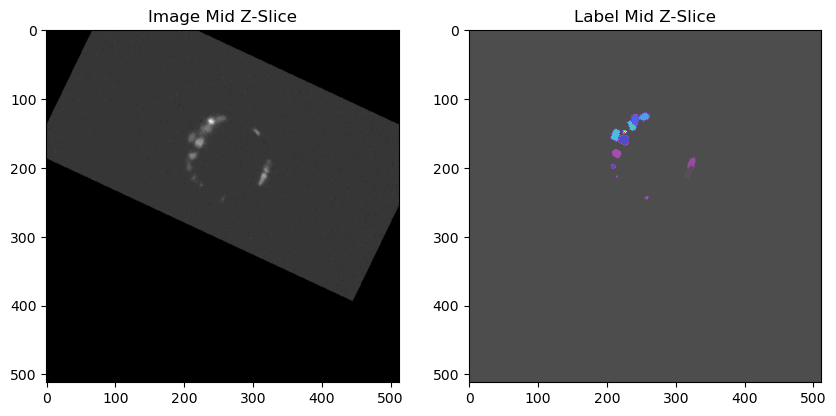

In [14]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Load the image and label stacks
img_path = "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/230212_stack6/registered_images/nuclei_reg8_190.tif"
label_path = "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/230212_stack6/registered_label_images/label_reg8_190.tif"

img_stack = tifffile.imread(img_path)
label_stack = tifffile.imread(label_path)

# Get the mid z-slice index
mid_z = img_stack.shape[0] // 2
center_y, center_x = img_stack.shape[1] // 2, img_stack.shape[2] // 2

# Show the mid z-slice (2D)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image Mid Z-Slice")
plt.imshow(img_stack[mid_z], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Label Mid Z-Slice")
plt.imshow(label_stack[mid_z], cmap="nipy_spectral", alpha=0.7)
plt.show()

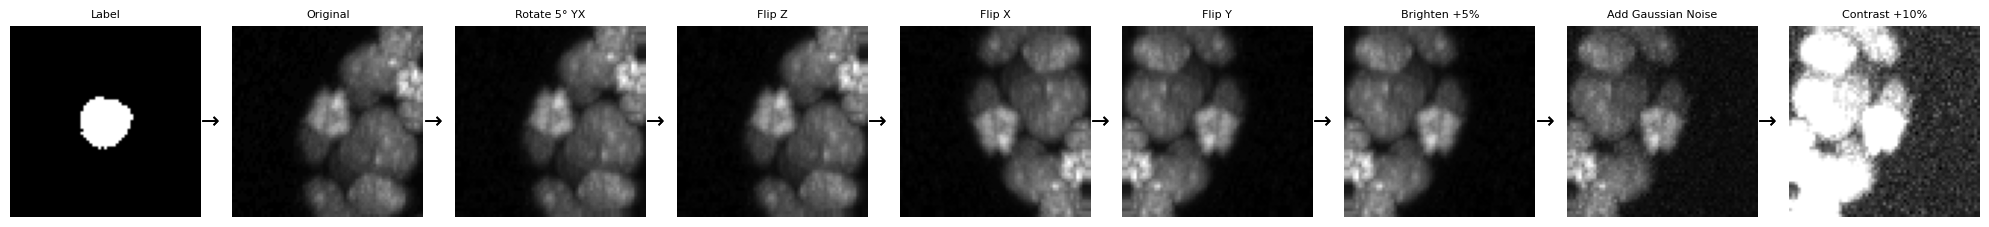

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage import exposure, util
from tifffile import imread

# Load your 3D image
folder_path = "/mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset/v3/mitotic/230212_stack6_frame_133_nucleus_029_count_49/t"
volume = imread(f"{folder_path}/raw_cropped.tif")
label_volume = imread(
    f"{folder_path}/binary_label_cropped.tif"
)

# --- FIX: Normalize the volume to a [0, 1] float range ---
# Convert to float and divide by the max possible value for its data type
volume = volume.astype(np.float32)
if np.max(volume) > 1.0:
    volume = volume / np.max(volume)


# --------- Transformation Functions ---------
def max_projection(vol):
    return np.max(vol, axis=0)


def rotate_yx(vol, angle=5):
    return rotate(vol, angle=angle, axes=(1, 2), reshape=False, mode="nearest")


def flip_x(vol):  # Vertical Flip
    return vol[:, ::-1, :]


def flip_y(vol):  # Horizontal Flip
    return vol[:, :, ::-1]


def flip_z(vol):  # Depth Flip
    return vol[::-1, :, :]


def adjust_brightness(vol, delta=0.05):
    # This now works correctly on the [0, 1] float data
    return np.clip(vol + delta, 0, 1)


def add_gaussian_noise(vol, var=0.001):
    return util.random_noise(vol, mode="gaussian", var=var, clip=True)


def adjust_contrast(vol, gain=1.1):
    # This function is generally okay but works best on [0, 1] data
    vol_flat = vol.flatten()
    p2, p98 = np.percentile(vol_flat, (2, 98))
    return exposure.rescale_intensity(vol, in_range=(p2, p98))


# --------- Transformation Pipeline ---------
rotated = rotate_yx(volume)
flipped_z = flip_z(rotated)
flipped_x = flip_x(flipped_z)
flipped_y = flip_y(flipped_x)
brightened = adjust_brightness(flipped_y)
noisy = add_gaussian_noise(brightened)
contrasted = adjust_contrast(noisy)

steps = [
    ("Label", label_volume),
    ("Original", volume),
    ("Rotate 5° YX", rotated),
    ("Flip Z", flipped_z),
    ("Flip X", flipped_x),
    ("Flip Y", flipped_y),
    ("Brighten +5%", brightened),
    ("Add Gaussian Noise", noisy),
    ("Contrast +10%", contrasted),
]

# --------- Plotting ---------
fig, axs = plt.subplots(1, len(steps), figsize=(20, 8))

for i, (title, vol) in enumerate(steps):
    axs[i].imshow(max_projection(vol), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(title, fontsize=8)

    if i < len(steps) - 1:
        axs[i].annotate(
            "→",
            xy=(1.05, 0.5),
            xytext=(1.05, 0.5),
            textcoords="axes fraction",
            ha="center",
            va="center",
            fontsize=16,
        )
for i, (title, vol) in enumerate(steps):
    # axs[i].imshow(max_projection(vol), cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(title, fontsize=8)

    if i < len(steps) - 1:
        axs[i].annotate(
            "→",
            xy=(1.05, 0.5),
            xytext=(1.05, 0.5),
            textcoords="axes fraction",
            ha="center",
            va="center",
            fontsize=16,
        )

plt.tight_layout()
plt.show()

✅ Plot successfully saved to 'final_distribution_plot.png'


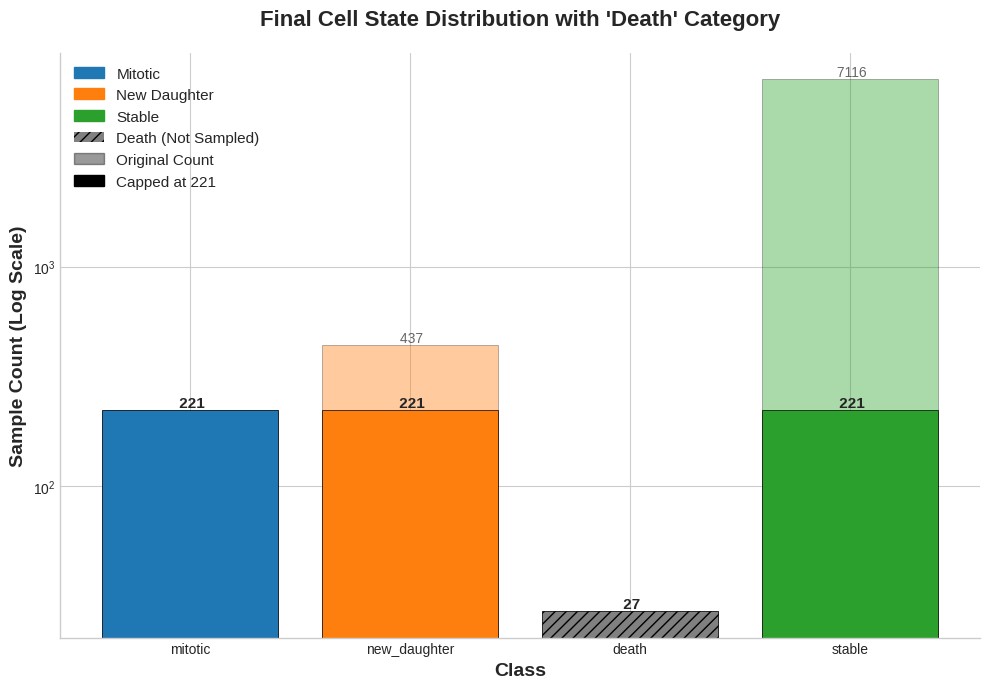

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches


def plot_final_distribution(counts, limit, title="Class Distribution", filename=None):
    """
    Generates a scientific bar chart with special notation for the 'death' category.

    Args:
        counts (dict): Dictionary of original class counts.
        limit (int): The count limit for balancing.
        title (str, optional): The plot title.
        filename (str, optional): Path to save the figure. If None, shows the plot.
    """
    # 1. --- Data Processing ---
    # We are no longer ignoring any classes
    labels = list(counts.keys())
    original_values = np.array(list(counts.values()))
    capped_values = np.array([min(v, limit) for v in original_values])

    # 2. --- Setup for Special Notation ---
    # Define colors and hatches based on the class label
    bar_colors = []
    bar_hatches = []
    # Assign gray color and hatch pattern only to the 'death' category
    for label in labels:
        if label == "death":
            bar_colors.append("gray")
            bar_hatches.append("///")
        elif label == "mitotic":
            bar_colors.append("#1f77b4")  # Blue
            bar_hatches.append(None)
        elif label == "new_daughter":
            bar_colors.append("#ff7f0e")  # Orange
            bar_hatches.append(None)
        elif label == "stable":
            bar_colors.append("#2ca02c")  # Green
            bar_hatches.append(None)

    # 3. --- Plotting ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(10, 7))

    # Plot ORIGINAL counts as faint bars, using the defined colors and hatches
    ax.bar(
        labels,
        original_values,
        color=bar_colors,
        hatch=bar_hatches,
        alpha=0.4,
        ec="black",
        lw=0.5,
    )

    # Plot CAPPED counts as solid bars on top
    ax.bar(
        labels,
        capped_values,
        color=bar_colors,
        hatch=bar_hatches,
        alpha=1.0,
        ec="black",
        lw=0.5,
    )

    # Use a logarithmic scale
    ax.set_yscale("log")

    # 4. --- Annotations and Legend ---
    # Annotate the bars
    for i, (orig_val, cap_val) in enumerate(zip(original_values, capped_values)):
        # Annotate the capped value
        ax.text(
            i,
            cap_val,
            f" {cap_val}",
            ha="center",
            va="bottom",
            fontsize=11,
            weight="bold",
        )
        # Annotate the original value only if it was actually capped
        if orig_val > cap_val:
            ax.text(
                i,
                orig_val,
                f" {orig_val}",
                ha="center",
                va="bottom",
                fontsize=10,
                alpha=0.7,
            )

    # Create a custom legend to explain the notation
    legend_patches = [
        mpatches.Patch(color="#1f77b4", label="Mitotic"),
        mpatches.Patch(color="#ff7f0e", label="New Daughter"),
        mpatches.Patch(color="#2ca02c", label="Stable"),
        mpatches.Patch(facecolor="gray", hatch="///", label="Death (Not Sampled)"),
        mpatches.Patch(color="black", alpha=0.4, label="Original Count"),
        mpatches.Patch(color="black", alpha=1.0, label=f"Capped at {limit}"),
    ]
    ax.legend(handles=legend_patches, fontsize=11)

    # 5. --- Final Touches ---
    ax.set_ylabel("Sample Count (Log Scale)", fontsize=14, weight="bold")
    ax.set_xlabel("Class", fontsize=14, weight="bold")
    ax.set_title(title, fontsize=16, weight="bold", pad=20)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()

    # 6. --- Save or Show ---
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        print(f"✅ Plot successfully saved to '{filename}'")
    else:
        plt.show()


# --- Example Usage ---
cell_counts = {"mitotic": 221, "new_daughter": 437, "death": 27, "stable": 7116}

plot_final_distribution(
    counts=cell_counts,
    limit=221,
    title="Final Cell State Distribution with 'Death' Category",
    filename="final_distribution_plot.png",
)

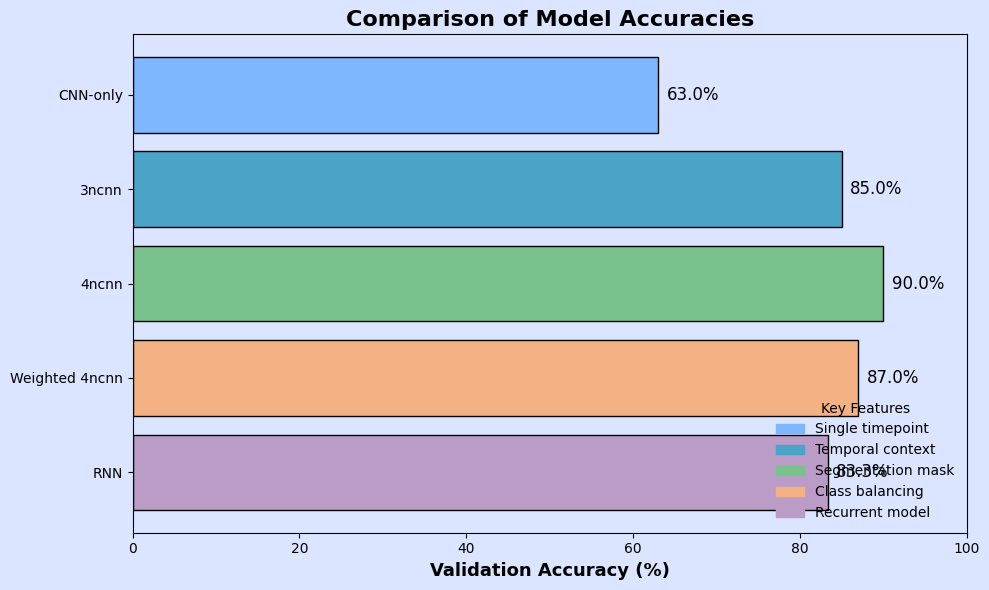

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- Model Data ----
models = [
    "CNN-only",
    "3ncnn",
    "4ncnn",
    "Weighted 4ncnn",
    "RNN"
]
accuracies = [63, 85, 90, 87, 83.33]
descriptions = [
    "Single timepoint",
    "Temporal context",
    "Segmentation mask",
    "Class balancing",
    "Recurrent model"
]
colors = ["#7EB6FF", "#4BA3C7", "#79C18C", "#F4B183", "#BA9CC7"]

# ---- RGB Background Color (clamped blue-ish) ----
# Note: 328 is not valid for RGB. Max is 255. We'll use a soft blue approximation.
background_rgb = (219 / 255, 229 / 255, 255 / 255)  # R=219, G=229, B=255

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(10, 6), facecolor=background_rgb)
bars = ax.barh(models, accuracies, color=colors, edgecolor='black')

# Annotate accuracy values
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
            f"{acc:.1f}%", va='center', fontsize=12)

# Style
ax.set_xlim(0, 100)
ax.set_xlabel("Validation Accuracy (%)", fontsize=13, weight='bold')
ax.set_title("Comparison of Model Accuracies", fontsize=16, weight='bold')
ax.invert_yaxis()
ax.set_facecolor(background_rgb)

# Transparent legend with no box
patches = [mpatches.Patch(color=c, label=desc) for c, desc in zip(colors, descriptions)]
legend = ax.legend(handles=patches, title="Key Features", loc="lower right", frameon=False)

plt.tight_layout()
plt.show()



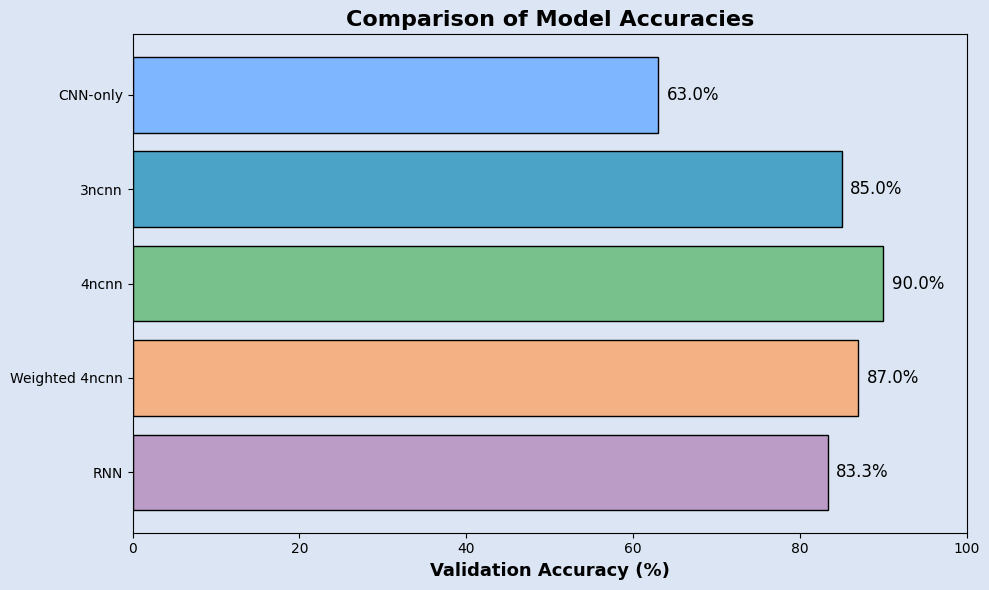

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---- Model Data ----
models = ["CNN-only", "3ncnn", "4ncnn", "Weighted 4ncnn", "RNN"]
accuracies = [63, 85, 90, 87, 83.33]
descriptions = [
    "Single timepoint",
    "Temporal context",
    "Segmentation mask",
    "Class balancing",
    "Recurrent model",
]
colors = ["#7EB6FF", "#4BA3C7", "#79C18C", "#F4B183", "#BA9CC7"]

# ---- RGB Background Color (clamped blue-ish) ----
# Note: 328 is not valid for RGB. Max is 255. We'll use a soft blue approximation.
background_rgb = (219 / 255, 229 / 255, 243 / 255)  # R=219, G=229, B=255

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(10, 6), facecolor=background_rgb)
bars = ax.barh(models, accuracies, color=colors, edgecolor="black")

# Annotate accuracy values
for bar, acc in zip(bars, accuracies):
    ax.text(
        bar.get_width() + 1,
        bar.get_y() + bar.get_height() / 2,
        f"{acc:.1f}%",
        va="center",
        fontsize=12,
    )

# Style
ax.set_xlim(0, 100)
ax.set_xlabel("Validation Accuracy (%)", fontsize=13, weight="bold")
ax.set_title("Comparison of Model Accuracies", fontsize=16, weight="bold")
ax.invert_yaxis()
ax.set_facecolor(background_rgb)

# Transparent legend with no box
# patches = [mpatches.Patch(color=c, label=desc) for c, desc in zip(colors, descriptions)]
# legend = ax.legend(
#     handles=patches, title="Key Features", loc="lower right", frameon=False
# )

plt.tight_layout()
plt.show()

Class 'death' found 24 images.
Class 'new_daughter' found 434 images.
Class 'mitotic' found 218 images.
Class 'stable' found 7113 images.


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/dchhantyal/3d-cnn-classification/model/notebooks/230212_stack6_frame_229_nucleus_036_count_103'

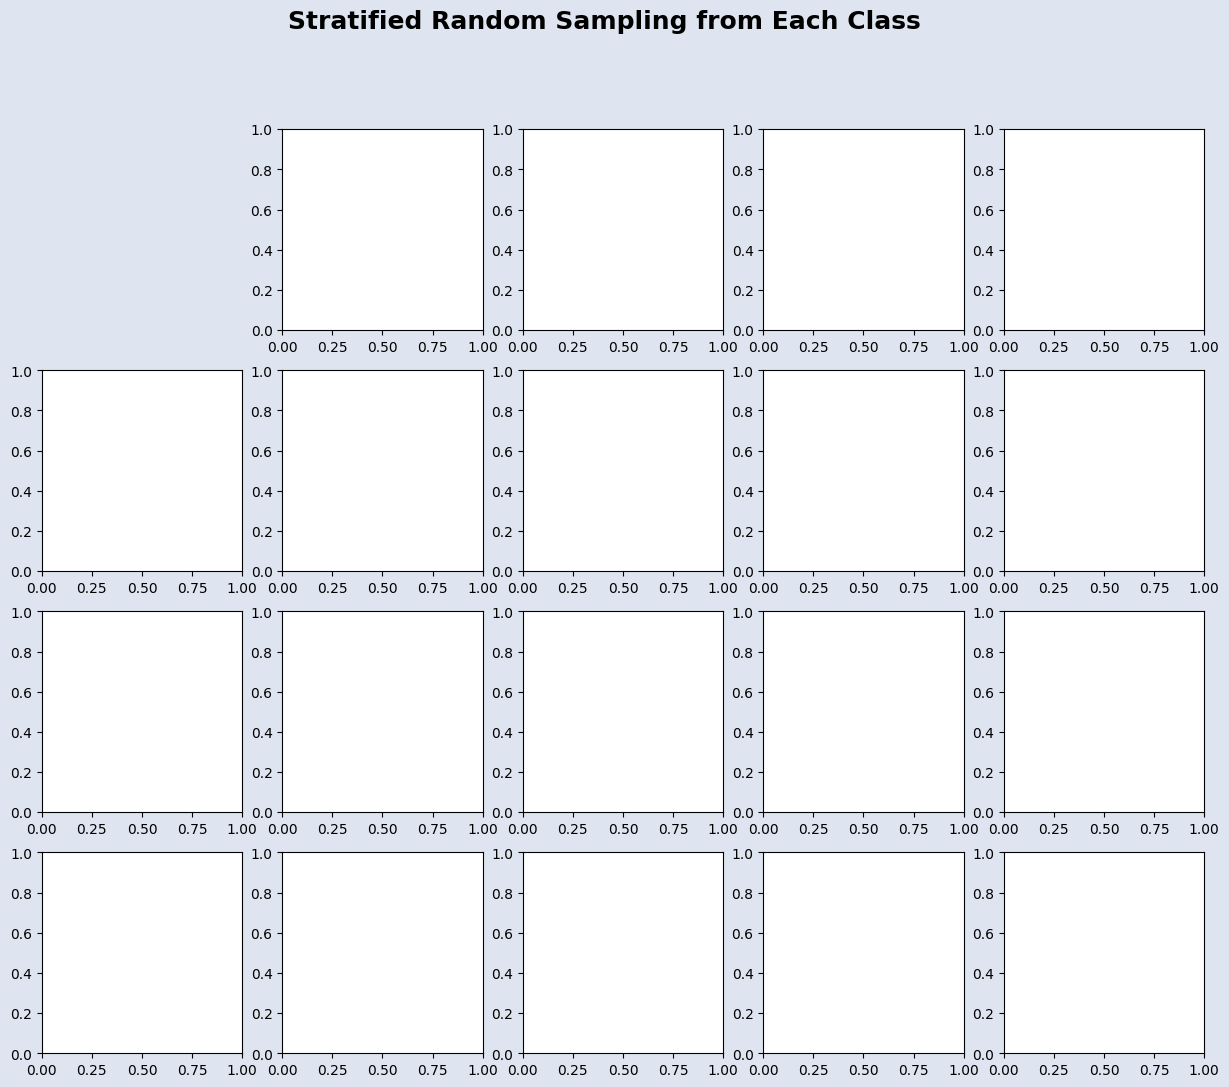

Generating synthetic data for Frame 1 (Fewer Nuclei)...
Generating synthetic data for Frame 2 (More Nuclei)...
Rendering 3D plot...


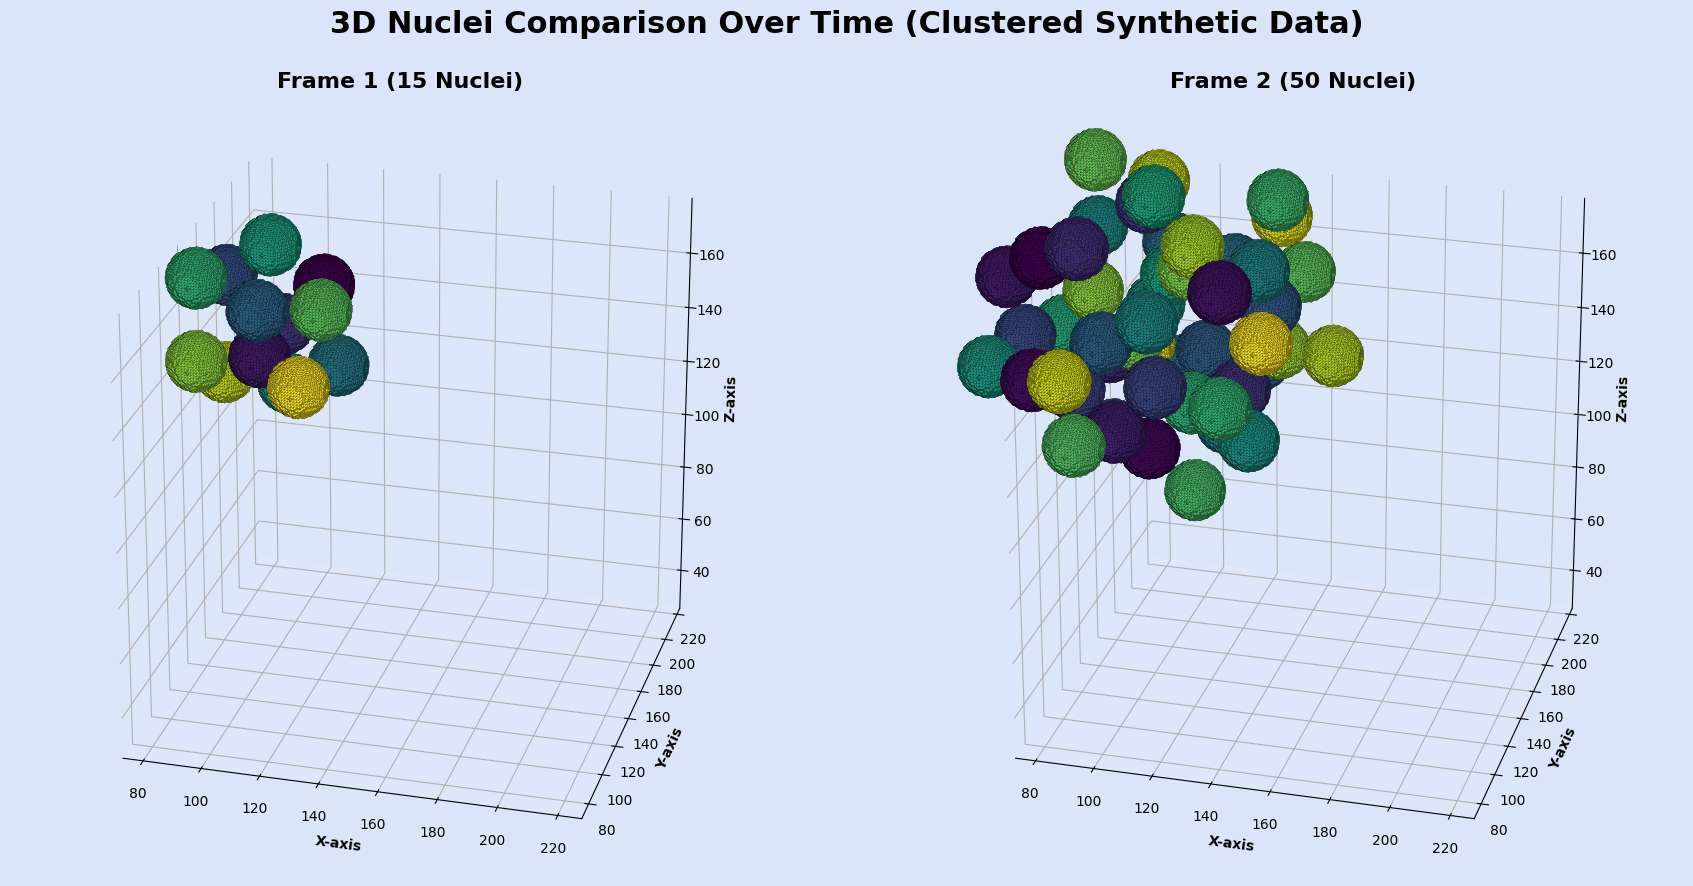

Done.


In [8]:
import tifffile
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure


def generate_clustered_nuclei_stack(
    shape, num_nuclei, cluster_center, cluster_radius, nucleus_radius=10
):
    """
    Creates a 3D numpy array with a specified number of spherical nuclei
    grouped together in a central cluster.

    Args:
        shape (tuple): The (Z, Y, X) dimensions of the output stack.
        num_nuclei (int): The number of nuclei to generate.
        cluster_center (tuple): The (z, y, x) center of the cell cluster.
        cluster_radius (int): The radius of the cluster area.
        nucleus_radius (int): The radius of each spherical nucleus.

    Returns:
        np.ndarray: A 3D label stack with synthetic nuclei.
    """
    stack = np.zeros(shape, dtype=np.uint16)
    zz, yy, xx = np.ogrid[: shape[0], : shape[1], : shape[2]]

    generated_nuclei = []

    for i in range(1, num_nuclei + 1):
        # Find a non-overlapping position for the new nucleus within the cluster
        for _ in range(100):  # Max 100 attempts to find a spot
            # Generate a random point within the spherical cluster
            phi = np.random.uniform(0, 2 * np.pi)
            costheta = np.random.uniform(-1, 1)
            u = np.random.uniform(0, 1)

            theta = np.arccos(costheta)
            r = cluster_radius * (u ** (1 / 3))

            # Convert spherical coordinates to cartesian coordinates around the cluster center
            center_x = int(cluster_center[2] + r * np.sin(theta) * np.cos(phi))
            center_y = int(cluster_center[1] + r * np.sin(theta) * np.sin(phi))
            center_z = int(cluster_center[0] + r * np.cos(theta))

            # Check for overlap with existing nuclei
            is_overlapping = False
            for existing_center, existing_radius in generated_nuclei:
                dist_sq = (
                    (center_x - existing_center[2]) ** 2
                    + (center_y - existing_center[1]) ** 2
                    + (center_z - existing_center[0]) ** 2
                )
                if dist_sq < (nucleus_radius + existing_radius) ** 2:
                    is_overlapping = True
                    break

            if not is_overlapping:
                break

        # Add the nucleus if a valid spot was found
        if not is_overlapping:
            generated_nuclei.append(((center_z, center_y, center_x), nucleus_radius))
            distance_sq = (
                (zz - center_z) ** 2 + (yy - center_y) ** 2 + (xx - center_x) ** 2
            )
            mask = distance_sq <= nucleus_radius**2
            stack[mask] = i

    return stack


def plot_nuclei_comparison_3d(stack1, stack2, title1, title2):
    """
    Creates a 3D side-by-side comparison of two nuclei label stacks.
    This version automatically centers and zooms the view on the nuclei.

    Args:
        stack1 (np.ndarray): The first 3D label stack.
        stack2 (np.ndarray): The second 3D label stack.
        title1 (str): Title for the first subplot.
        title2 (str): Title for the second subplot.
    """
    # --- 1. Setup Figure and Colors ---
    bgcolor = (219 / 255, 229 / 255, 249 / 255)
    fig, (ax1, ax2) = plt.subplots(
        1, 2, figsize=(18, 9), subplot_kw={"projection": "3d"}
    )
    fig.set_facecolor(bgcolor)
    fig.suptitle(
        "3D Nuclei Comparison Over Time (Clustered Synthetic Data)",
        fontsize=22,
        weight="bold",
    )

    # --- 2. Process Data ---
    stacks = [stack1, stack2]
    axes = [ax1, ax2]
    titles = [title1, title2]

    # --- Calculate Global Bounding Box to Center and Zoom ---
    all_coords = []
    for stack in stacks:
        coords = np.argwhere(stack > 0)
        if coords.size > 0:
            all_coords.append(coords)

    if not all_coords:
        print("Error: No nuclei found in the generated data.")
        return

    all_coords = np.vstack(all_coords)
    z_min, y_min, x_min = all_coords.min(axis=0)
    z_max, y_max, x_max = all_coords.max(axis=0)

    center_z, center_y, center_x = (
        (z_min + z_max) / 2,
        (y_min + y_max) / 2,
        (x_min + x_max) / 2,
    )
    max_range = (
        np.max([x_max - x_min, y_max - y_min, z_max - z_min]) * 1.2
    )  # 20% padding
    half_range = max_range / 2

    tight_xlim = (center_x - half_range, center_x + half_range)
    tight_ylim = (center_y - half_range, center_y + half_range)
    tight_zlim = (center_z - half_range, center_z + half_range)

    # --- 3. Render Each Frame ---
    for ax, stack, title in zip(axes, stacks, titles):
        nucleus_ids = np.unique(stack)[1:]
        colors = plt.cm.viridis(np.linspace(0, 1, len(nucleus_ids)))

        for i, nucleus_id in enumerate(nucleus_ids):
            nucleus_mask = stack == nucleus_id
            try:
                verts, faces, _, _ = measure.marching_cubes(
                    nucleus_mask, level=0.5, spacing=(1.0, 1.0, 1.0)
                )
                mesh = Poly3DCollection(verts[faces])
                mesh.set_facecolor(colors[i])
                mesh.set_edgecolor("k")
                mesh.set_linewidth(0.1)
                ax.add_collection3d(mesh)
            except (ValueError, RuntimeError) as e:
                print(f"Skipping nucleus {nucleus_id} due to marching_cubes error: {e}")

        # --- 4. Configure Subplot Aesthetics ---
        ax.set_title(title, fontsize=16, weight="bold")
        ax.set_facecolor(bgcolor)
        ax.set_xlim(tight_xlim)
        ax.set_ylim(tight_ylim)
        ax.set_zlim(tight_zlim)
        ax.set_xlabel("X-axis", weight="bold")
        ax.set_ylabel("Y-axis", weight="bold")
        ax.set_zlabel("Z-axis", weight="bold")
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.05))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.05))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
        ax.set_box_aspect((max_range, max_range, max_range))
        ax.view_init(elev=25, azim=-75)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# --- Main Execution ---
if __name__ == "__main__":
    # Define the shape of our 3D space
    stack_shape = (200, 300, 300)

    # Define the center and radius of the cell cluster
    cluster_center_point = (
        stack_shape[0] // 2,
        stack_shape[1] // 2,
        stack_shape[2] // 2,
    )

    # Generate the first frame with fewer nuclei in a smaller cluster
    print("Generating synthetic data for Frame 1 (Fewer Nuclei)...")
    stack_frame1 = generate_clustered_nuclei_stack(
        shape=stack_shape,
        num_nuclei=15,
        cluster_center=cluster_center_point,
        cluster_radius=30,
        nucleus_radius=10,
    )

    # Generate the second frame with more nuclei in a larger cluster to show growth
    print("Generating synthetic data for Frame 2 (More Nuclei)...")
    stack_frame2 = generate_clustered_nuclei_stack(
        shape=stack_shape,
        num_nuclei=50,
        cluster_center=cluster_center_point,
        cluster_radius=60,
        nucleus_radius=10,
    )

    print("Rendering 3D plot...")
    plot_nuclei_comparison_3d(
        stack_frame1,
        stack_frame2,
        title1="Frame 1 (15 Nuclei)",
        title2="Frame 2 (50 Nuclei)",
    )
    print("Done.")

In [9]:
from tifffile import imread
import numpy as np
from pathlib import Path
import random

# Path to your label images
label_path_dir = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_label_images"
)

# Get all label files
label_files = list(label_path_dir.glob("*.tif"))
if not label_files:
    print("No label files found.")
else:
    # Pick a random file
    label_file = random.choice(label_files)
    label_volume = imread(label_file)
    print(f"Random label file: {label_file}")
    print(f"Shape (z, y, x): {label_volume.shape}")

    # Calculate the z size needed for a flat 32x32 (xy) area
    y, x = label_volume.shape[1], label_volume.shape[2]
    z = label_volume.shape[0]
    print(f"Current XY: {y}x{x}, Z: {z}")
    if y >= 32 and x >= 32:
        print("You can crop to 32x32 in XY. Z remains:", z)
    else:
        print(
            "Volume is smaller than 32x32 in XY. Consider upsampling or using a smaller crop."
        )

Random label file: /mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_label_images/label_reg8_102.tif
Shape (z, y, x): (252, 512, 512)
Current XY: 512x512, Z: 252
You can crop to 32x32 in XY. Z remains: 252
